In [1]:

import diffrax
from diffrax import diffeqsolve, ODETerm, Dopri5,SaveAt
import numpy as np
import jax.numpy as jnp
import jax

import equinox as eqx  # https://github.com/patrick-kidger/equinox
import matplotlib.pyplot as plt
import optax
import pandas as pd
import logging

logging.basicConfig(filename='errors.log', level=logging.ERROR)
jax.config.update("jax_enable_x64", True)

[{'p_qsmax': -0.496786299174752, 'p_Ks': 0.022203577963219756, 'p_a': -1.5339731910623735, 'p_ms': -0.1596953272415843}, {'p_qsmax': -0.11583705326160798, 'p_Ks': 0.008429263674520049, 'p_a': -1.7962602101156322, 'p_ms': -0.04466251477017527}, {'p_qsmax': -0.18063573579831316, 'p_Ks': 0.08903712935134696, 'p_a': -1.545465260435651, 'p_ms': -0.11328211276642769}, {'p_qsmax': -0.12810958045711013, 'p_Ks': 0.010588506045865543, 'p_a': -1.6908284159135505, 'p_ms': -0.12977905688534508}, {'p_qsmax': -0.49062732354509075, 'p_Ks': 0.07295466085059656, 'p_a': -1.7561568099388924, 'p_ms': -0.00938038592045115}, {'p_qsmax': -0.37469907300318445, 'p_Ks': 0.09948749985789831, 'p_a': -1.4491438738033797, 'p_ms': -0.060124496736769145}, {'p_qsmax': -0.28266298232597536, 'p_Ks': 0.030978370799502976, 'p_a': -1.4721682709724684, 'p_ms': -0.17526859750538534}, {'p_qsmax': -0.11074925727625318, 'p_Ks': 0.016779088940390496, 'p_a': -1.6484879790679343, 'p_ms': -0.09540377423433617}, {'p_qsmax': -0.212809

/tmp/ipykernel_52201/3821743987.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  random_init[name]=float(np.random.uniform(bounds[name]['lb'],bounds[name]['ub'],size=1))


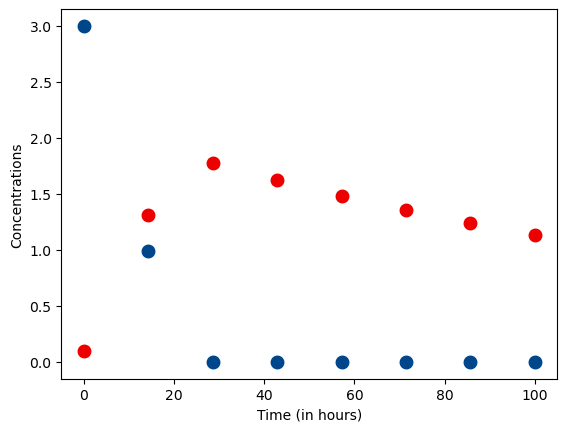

In [2]:
params={"p_qsmax":-0.3,"p_Ks":0.01,"p_a":-1.6,"p_ms":-0.01}




class Bioprocess_4p():
    def __init__(self):
        super().__init__()
    
    def __call__(self,t,y,args):
        params=args[0]
        
        qs=params['p_qsmax']*(y[0]/(params['p_Ks']+y[0]))
        qx=(qs-params['p_ms'])/params['p_a']

        Rs=qs*y[1]
        Rx=qx*y[1]
        dY=jnp.stack([Rs,Rx])
        return dY

class NeuralODE():
    func : Bioprocess_4p()

    def __init__(self):
        super().__init__()

        self.func=Bioprocess_4p()

    def __call__(self,ts,y0,params):
        solution = diffrax.diffeqsolve(
        diffrax.ODETerm(self.func),
        diffrax.Kvaerno3(),
        t0=ts[0],
        t1=ts[-1],
        dt0=ts[1] - ts[0],
        y0=y0,
        args=[params],
        stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-8),
        saveat=diffrax.SaveAt(ts=ts),
        max_steps=10000
        )
        return solution.ys



model_bioprocess=NeuralODE()
model_bioprocess=jax.jit(model_bioprocess)

ts=jnp.linspace(0,100,8)

y_names=["S",'Biomass']
y0=jnp.array([3,0.1])

ys=model_bioprocess(ts=ts,y0=y0,params=params)

plt.scatter(ts,ys[:,0],label=y_names[0],linewidth=4,c="#00468BFF")
plt.scatter(ts,ys[:,1],label=y_names[1],linewidth=4,c="#ED0000FF")
plt.xlabel("Time (in hours)")
plt.ylabel("Concentrations")



def uniform_sampling(bounds,N):
    """Takes a uniform sample between lower and upperbound values"""
    parameter_sets=[]
    names=list(bounds.keys())
    for i in range(N):
        random_init={}
        for name in names:
            random_init[name]=float(np.random.uniform(bounds[name]['lb'],bounds[name]['ub'],size=1))
        parameter_sets.append(random_init)

    return parameter_sets

##initialize prediction dataset
bounds=pd.read_csv("batch_bounds.csv",index_col=0).T


bounds=dict(bounds)
parameter_sets=uniform_sampling(bounds,100)
print(parameter_sets)
# print(params_initial_guess)
# ts_ig=jnp.linspace(0,100,100)
# ys_ig=model_bioprocess(ts=ts_ig,y0=y0,params=params_initial_guess)

# plt.plot(ts_ig,ys_ig[:,0],label="S (initial guess)",linewidth=2,c="#0099B4FF")
# plt.plot(ts_ig,ys_ig[:,1],label="X (initial guess)",linewidth=2,c="#AD002AFF")
# plt.xlabel("Time (in hours)")
# plt.ylabel("Concentrations")
# plt.legend()

In [26]:
ys=ys.at[2,1].set(np.nan)
ys=ys.at[5,0].set(np.nan)


Array([[ 3.00000000e+00,  1.00000000e-01],
       [ 9.88621809e-01,  1.31497778e+00],
       [ 1.13929390e-11,             nan],
       [-4.96787640e-13,  1.62036763e+00],
       [-2.67265778e-13,  1.48189849e+00],
       [            nan,  1.35529875e+00],
       [ 2.21980077e-15,  1.23951476e+00],
       [-1.08746334e-18,  1.13362883e+00]], dtype=float64)

In [42]:
# ### simple learning system to test whether grads works as expected
def loss_func(params,ts,ys):
    """mean squared error"""
    
    mask=~jnp.isnan(jnp.array(ys))
    yscale=jnp.nanmax(ys,axis=0)-jnp.nanmin(ys,axis=0)
    y_pred=model_bioprocess(ts,y0,params)*(1/yscale)

    ys=ys*(1/yscale)

    ys = jnp.where(mask, ys, 0)
    y_pred = jnp.where(mask, y_pred, 0)
    non_nan_count = jnp.sum(mask)

    loss = jnp.sum((y_pred - ys) ** 2) / non_nan_count


    return loss

loss_func(params,ts,ys)
@jax.jit
def update(opt_state,params,ts,ys):
    """Update rule for the gradients for parameters"""
    loss=loss_func(params,ts,ys)
    grads=jax.jit(jax.grad(loss_func,0))(params,ts,ys) #loss w.r.t. parameters
    updates,opt_state=optimizer.update(grads,opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state,params,loss,grads



14


In [43]:
epochs=50



loss_per_param={}
final_loss=[]

for i in range(len(parameter_sets)):
    print(i)
    params_init=parameter_sets[i]
    lr=1e-4
    optimizer = optax.adabelief(lr)
    opt_state = optimizer.init(params_init)
    loss_per_iter=[]
    for _ in range(epochs):
        try:
            opt_state,params_init,loss,grads=update(opt_state,params_init,ts,ys)
        except Exception as e:
            logging.error(f"Error for {i}: {e}")
        loss_per_iter.append(loss)
    
    final_loss.append(loss)

    loss_per_param[i]=loss_per_iter


0
Traced<ShapedArray(int64[])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(int64[])>with<DynamicJaxprTrace(level=2/0)>
Traced<ShapedArray(int64[])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(int64[])>with<DynamicJaxprTrace(level=2/0)>
Traced<ShapedArray(int64[])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(int64[])>with<DynamicJaxprTrace(level=2/0)>
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [44]:
df=pd.DataFrame(loss_per_param)
np.argmin(df.iloc[-1,:])

36

In [47]:

params_init=parameter_sets[np.argmin(final_loss)]

lr=1e-4
optimizer = optax.adabelief(lr)
opt_state = optimizer.init(params_init)
epochs=1000


losses=[]
for _ in range(epochs):
    try:
        opt_state,params_init,loss,grads=update(opt_state,params_init,ts,ys)
    except Exception as e:
        logging.error(f"Error for {i}: {e}")
    losses.append(loss)


In [48]:
losses

[Array(0.00790121, dtype=float64),
 Array(0.00760216, dtype=float64),
 Array(0.00729329, dtype=float64),
 Array(0.00697549, dtype=float64),
 Array(0.00664981, dtype=float64),
 Array(0.00631746, dtype=float64),
 Array(0.00597985, dtype=float64),
 Array(0.00563852, dtype=float64),
 Array(0.00529519, dtype=float64),
 Array(0.00495173, dtype=float64),
 Array(0.00461011, dtype=float64),
 Array(0.0042724, dtype=float64),
 Array(0.00394075, dtype=float64),
 Array(0.00361729, dtype=float64),
 Array(0.0033043, dtype=float64),
 Array(0.00300349, dtype=float64),
 Array(0.00271693, dtype=float64),
 Array(0.0024463, dtype=float64),
 Array(0.00219305, dtype=float64),
 Array(0.00195834, dtype=float64),
 Array(0.00174298, dtype=float64),
 Array(0.00154745, dtype=float64),
 Array(0.00137186, dtype=float64),
 Array(0.00121596, dtype=float64),
 Array(0.00107922, dtype=float64),
 Array(0.00096034, dtype=float64),
 Array(0.00085949, dtype=float64),
 Array(0.00077409, dtype=float64),
 Array(0.00070312, dtyp

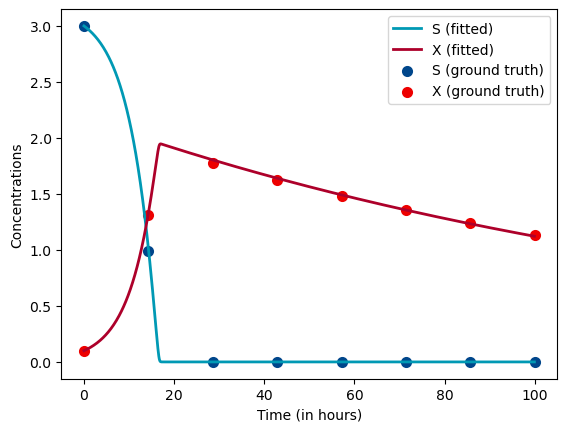

In [49]:
# plt.title("Training")
# plt.plot(losses[0:200])
# plt.xlabel("iterations")
# plt.ylabel("Loss ($(y_{pred}-y_{true})**2$)")

t_pred=jnp.arange(0,100,0.1)
ys_pred=model_bioprocess(t_pred,y0,params=params_init)


ys_true=model_bioprocess(ts,y0,params=params)

plt.plot(t_pred,ys_pred[:,0],label="S (fitted)",linewidth=2,c="#0099B4FF")
plt.plot(t_pred,ys_pred[:,1],label="X (fitted)",linewidth=2,c="#AD002AFF")
plt.scatter(ts,ys_true[:,0],label="S (ground truth)",linewidth=2,c="#00468BFF")
plt.scatter(ts,ys_true[:,1],label="X (ground truth)",linewidth=2,c="#ED0000FF")
plt.xlabel("Time (in hours)")
plt.ylabel("Concentrations")
plt.legend()